# Chapter 6: Optimization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.sans-serif'] = 'stix'

In [2]:
import numpy as np

In [3]:
import sympy

In [4]:
sympy.init_printing()

In [5]:
from scipy import optimize

In [6]:
import cvxopt

In [7]:
from __future__ import division

## Univariate

In [8]:
r, h = sympy.symbols("r, h")

In [9]:
Area = 2 * sympy.pi * r**2 + 2 * sympy.pi * r * h

In [10]:
Volume = sympy.pi * r**2 * h

In [11]:
h_r = sympy.solve(Volume - 1)[0]

In [12]:
Area_r = Area.subs(h_r)

In [13]:
rsol = sympy.solve(Area_r.diff(r))[0]

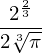

In [14]:
rsol

In [15]:
_.evalf()

In [16]:
# verify that the second derivative is positive, so that rsol is a minimum
Area_r.diff(r, 2).subs(r, rsol)

In [17]:
Area_r.subs(r, rsol)

In [18]:
_.evalf()

In [19]:
def f(r):
    return 2 * np.pi * r**2 + 2 / r

In [20]:
r_min = optimize.brent(f, brack=(0.1, 4))

In [21]:
r_min

In [22]:
f(r_min)

In [23]:
optimize.minimize_scalar(f, bracket=(0.1, 4))

     fun: 5.535810445932086
    nfev: 19
     nit: 15
 success: True
       x: 0.5419260772557135

In [24]:
r = np.linspace(0, 2, 100)[1:]

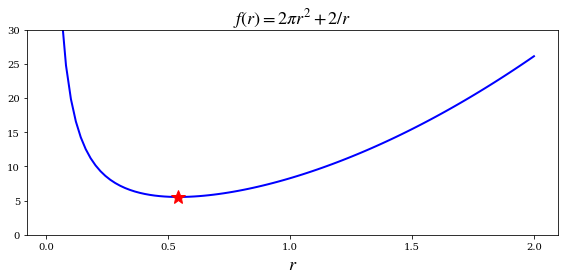

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(r, f(r), lw=2, color='b')
ax.plot(r_min, f(r_min), 'r*', markersize=15)
ax.set_title(r"$f(r) = 2\pi r^2+2/r$", fontsize=18)
ax.set_xlabel(r"$r$", fontsize=18)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_ylim(0, 30)

fig.tight_layout()
#fig.savefig('ch6-univariate-optimization-example.pdf')

## Two-dimensional

In [26]:
x1, x2 = sympy.symbols("x_1, x_2")

In [27]:
f_sym = (x1-1)**4 + 5 * (x2-1)**2 - 2*x1*x2

In [28]:
fprime_sym = [f_sym.diff(x_) for x_ in (x1, x2)]

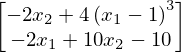

In [29]:
# Gradient
sympy.Matrix(fprime_sym)

In [30]:
fhess_sym = [[f_sym.diff(x1_, x2_) for x1_ in (x1, x2)] for x2_ in (x1, x2)]

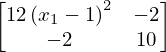

In [31]:
# Hessian
sympy.Matrix(fhess_sym)

In [32]:
f_lmbda = sympy.lambdify((x1, x2), f_sym, 'numpy')

In [33]:
fprime_lmbda = sympy.lambdify((x1, x2), fprime_sym, 'numpy')

In [34]:
fhess_lmbda = sympy.lambdify((x1, x2), fhess_sym, 'numpy')

In [35]:
def func_XY_X_Y(f):
    """
    Wrapper for f(X) -> f(X[0], X[1])
    """
    return lambda X: np.array(f(X[0], X[1]))

In [36]:
f = func_XY_X_Y(f_lmbda)

In [37]:
fprime = func_XY_X_Y(fprime_lmbda)

In [38]:
fhess = func_XY_X_Y(fhess_lmbda)

In [39]:
X_opt = optimize.fmin_ncg(f, (0, 0), fprime=fprime, fhess=fhess)

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 17
         Hessian evaluations: 8


In [40]:
X_opt

array([1.88292613, 1.37658523])

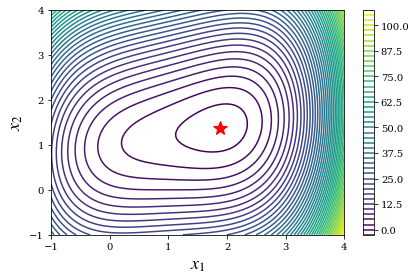

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, f_lmbda(X, Y), 50)
ax.plot(X_opt[0], X_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
fig.tight_layout()
#fig.savefig('ch6-examaple-two-dim.pdf');

## Brute force search for initial point

In [42]:
def f(X):
    x, y = X
    return (4 * np.sin(np.pi * x) + 6 * np.sin(np.pi * y)) + (x - 1)**2 + (y - 1)**2

In [43]:
x_start = optimize.brute(f, (slice(-3, 5, 0.5), slice(-3, 5, 0.5)), finish=None)

In [44]:
x_start

array([1.5, 1.5])

In [45]:
f(x_start)

In [46]:
x_opt = optimize.fmin_bfgs(f, x_start)

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 7


In [47]:
x_opt

array([1.47586906, 1.48365787])

In [48]:
f(x_opt)

In [49]:
def func_X_Y_to_XY(f, X, Y):
    s = np.shape(X)
    return f(np.vstack([X.ravel(), Y.ravel()])).reshape(*s)

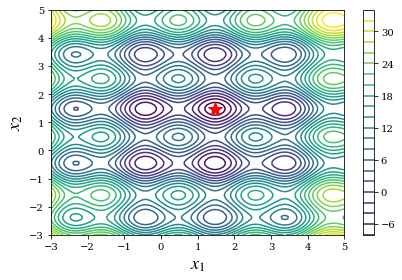

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 25)
ax.plot(x_opt[0], x_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
fig.tight_layout()
#fig.savefig('ch6-example-2d-many-minima.pdf');

## Nonlinear least square

In [51]:
def f(x, beta0, beta1, beta2):
    return beta0 + beta1 * np.exp(-beta2 * x**2)

In [52]:
beta = (0.25, 0.75, 0.5)

In [53]:
xdata = np.linspace(0, 5, 50)

In [54]:
y = f(xdata, *beta)

In [55]:
ydata = y + 0.05 * np.random.randn(len(xdata))

In [56]:
def g(beta):
    return ydata - f(xdata, *beta)

In [57]:
beta_start = (1, 1, 1)

In [58]:
beta_opt, beta_cov = optimize.leastsq(g, beta_start)

In [59]:
beta_opt

array([0.23670561, 0.74626821, 0.43670058])

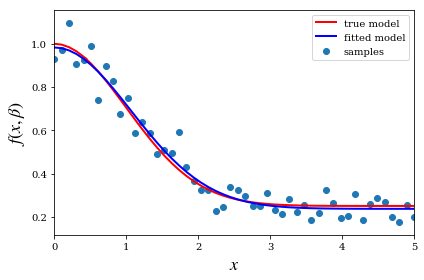

In [60]:
fig, ax = plt.subplots()

ax.scatter(xdata, ydata, label="samples")
ax.plot(xdata, y, 'r', lw=2, label="true model")
ax.plot(xdata, f(xdata, *beta_opt), 'b', lw=2, label="fitted model")
ax.set_xlim(0, 5)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x, \beta)$", fontsize=18)
ax.legend()
fig.tight_layout()
#fig.savefig('ch6-nonlinear-least-square.pdf')

In [61]:
beta_opt, beta_cov = optimize.curve_fit(f, xdata, ydata)

In [62]:
beta_opt

array([0.23670561, 0.74626821, 0.43670058])

## Constrained optimization

### Bounds

In [63]:
def f(X):
    x, y = X
    return (x-1)**2 + (y-1)**2

In [64]:
x_opt = optimize.minimize(f, [0, 0], method='BFGS').x

In [65]:
bnd_x1, bnd_x2 = (2, 3), (0, 2)

In [66]:
x_cons_opt = optimize.minimize(f, [0, 0], method='L-BFGS-B', bounds=[bnd_x1, bnd_x2]).x

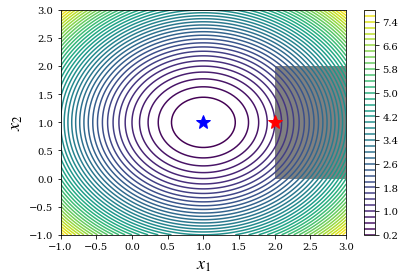

In [67]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)
bound_rect = plt.Rectangle((bnd_x1[0], bnd_x2[0]), 
                           bnd_x1[1] - bnd_x1[0], bnd_x2[1] - bnd_x2[0],
                           facecolor="grey")
ax.add_patch(bound_rect)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

fig.tight_layout()
#fig.savefig('ch6-example-constraint-bound.pdf');

## Lagrange multiplier

In [68]:
x = x1, x2, x3, l = sympy.symbols("x_1, x_2, x_3, lambda")

In [69]:
f = x1 * x2 * x3

In [70]:
g = 2 * (x1 * x2 + x2 * x3 + x3 * x1) - 1

In [71]:
L = f + l * g

In [72]:
grad_L = [sympy.diff(L, x_) for x_ in x]

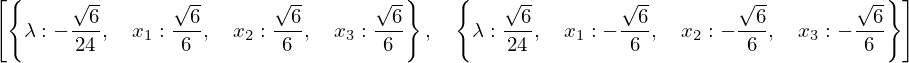

In [73]:
sols = sympy.solve(grad_L)
sols

In [74]:
g.subs(sols[0])

In [75]:
f.subs(sols[0])

In [76]:
def f(X):
    return -X[0] * X[1] * X[2]

In [77]:
def g(X):
    return 2 * (X[0]*X[1] + X[1] * X[2] + X[2] * X[0]) - 1

In [78]:
constraints = [dict(type='eq', fun=g)]

In [79]:
result = optimize.minimize(f, [0.5, 1, 1.5], method='SLSQP', constraints=constraints)

In [80]:
result

     fun: -0.06804136862287297
     jac: array([-0.16666925, -0.16666542, -0.16666526])
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([0.40824188, 0.40825127, 0.40825165])

In [81]:
result.x

array([0.40824188, 0.40825127, 0.40825165])

## Inequality constraints

In [82]:
def f(X):
    return (X[0] - 1)**2 + (X[1] - 1)**2

def g(X):
    return X[1] - 1.75 - (X[0] - 0.75)**4

In [83]:
%time x_opt = optimize.minimize(f, (0, 0), method='BFGS').x

Wall time: 2 ms


In [84]:
constraints = [dict(type='ineq', fun=g)]

In [85]:
%time x_cons_opt = optimize.minimize(f, (0, 0), method='SLSQP', constraints=constraints).x

Wall time: 8 ms


In [86]:
%time x_cons_opt = optimize.minimize(f, (0, 0), method='COBYLA', constraints=constraints).x

Wall time: 32 ms


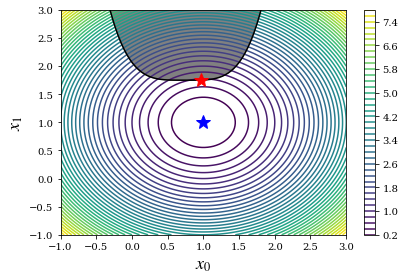

In [87]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)

ax.plot(x_, 1.75 + (x_-0.75)**4, 'k-', markersize=15)
ax.fill_between(x_, 1.75 + (x_-0.75)**4, 3, color="grey")
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)

ax.set_ylim(-1, 3)
ax.set_xlabel(r"$x_0$", fontsize=18)
ax.set_ylabel(r"$x_1$", fontsize=18)
plt.colorbar(c, ax=ax)

fig.tight_layout()
#fig.savefig('ch6-example-constraint-inequality.pdf');

## Linear programming

In [88]:
c = np.array([-1.0, 2.0, -3.0])

A = np.array([[ 1.0, 1.0, 0.0],
              [-1.0, 3.0, 0.0],
              [ 0.0, -1.0, 1.0]])

b = np.array([1.0, 2.0, 3.0])

In [89]:
A_ = cvxopt.matrix(A)
b_ = cvxopt.matrix(b)
c_ = cvxopt.matrix(c)

In [90]:
sol = cvxopt.solvers.lp(c_, A_, b_)

Optimal solution found.


In [91]:
x = np.array(sol['x'])

In [92]:
x

array([[0.25],
       [0.75],
       [3.75]])

In [93]:
sol

{'x': <3x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <3x1 matrix, tc='d'>,
 'z': <3x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 0.0,
 'relative gap': 0.0,
 'primal objective': -10.0,
 'dual objective': -10.0,
 'primal infeasibility': 0.0,
 'primal slack': -0.0,
 'dual slack': 0.0,
 'dual infeasibility': 1.4835979218054372e-16,
 'residual as primal infeasibility certificate': None,
 'residual as dual infeasibility certificate': None,
 'iterations': 0}

In [94]:
sol['primal objective']

## Quandratic problem with cvxopt

Quadratic problem formulation:
    
$\min \frac{1}{2}x^TPx + q^T x$

$G x \leq h$ 

For example, let's solve the problem

min $f(x_1, x_2) = (x_1 - 1)^2 + (x_2 - 1)^2 =$

$x_1^2 -2x_1 + 1 + x_2^2 - 2x_2 + 1 = $

$x_1^2 + x_2^2 - 2x_1 - 2x_2 + 2 =$

$= \frac{1}{2} x^T P x - q^T x + 2$

and

$\frac{3}{4} x_1 + x_2 \geq 3$, $x_1 \geq 0$

where

$P = 2 [[1, 0], [0, 1]]$ and $q = [-2, -2]$

and

$G = [[-3/4, -1], [-1, 0]]$ and $h = [-3, 0]$

In [95]:
from cvxopt import matrix, solvers

P = 2 * np.array([[1.0, 0.0],
                  [0.0, 1.0]])
q = np.array([-2.0, -2.0])

G = np.array([[-0.75, -1.0],
              [-1.0,  0.0]])

h = np.array([-3.0, 0.0])

In [96]:
_P = cvxopt.matrix(P)
_q = cvxopt.matrix(q)
_G = cvxopt.matrix(G)
_h = cvxopt.matrix(h)

In [97]:
%time sol = solvers.qp(_P, _q, _G, _h)

     pcost       dcost       gap    pres   dres
 0: -1.7901e+00 -2.0988e-01  6e+00  9e-01  1e+00
 1: -7.1216e-01 -1.2878e+00  6e-01  1e-16  3e-16
 2: -9.9733e-01 -1.0027e+00  5e-03  0e+00  8e-17
 3: -9.9997e-01 -1.0000e+00  5e-05  2e-16  0e+00
 4: -1.0000e+00 -1.0000e+00  5e-07  1e-16  1e-16
Optimal solution found.
Wall time: 66 ms


In [98]:
# sol

In [99]:
x = sol['x']

In [100]:
x = np.array(x)

In [101]:
sol['primal objective'] + 2

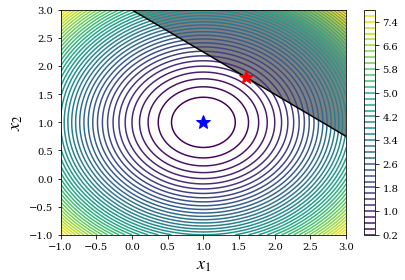

In [103]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)



y_ = (h[0] - G[0, 0] * x_)/G[0, 1]
mask = y_ < 3
angle = -np.arctan((y_[mask][0] - y_[mask][-1]) / (x_[mask][-1]- x_[mask][0])) * 180 / np.pi

ax.plot(x_, y_, 'k')
ax.add_patch(plt.Rectangle((0, 3), 4, 3, angle=angle, facecolor="grey"))

ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x[0], x[1], 'r*', markersize=15)

ax.set_ylim(-1, 3)
ax.set_xlim(-1, 3)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

fig.tight_layout()
#fig.savefig('ch6-example-quadratic-problem-constraint-inequality.pdf');